In [2]:
import numpy as np
from os import path
from operator import itemgetter
import matplotlib.pyplot as plt
from random import randint
from random import gauss
from random import choice

In [3]:
# Globals
DIST_THRESH = 0.01
SPATIAL_OBFUSCATION = 0.01
TIME_OBFUSCATION = 2.0

In [4]:
def load_poi_data():
    cwd = path.dirname("__file__")
    dat = np.loadtxt(path.join(cwd, 'pois.csv'), delimiter=" ", dtype=object, skiprows=1)
    poi_ids = dat[:, 0].astype(int)
    poi_type = dat[:, 2]
    poi_loc = dat[:, -2:].astype(float)

    return poi_ids, poi_type, poi_loc

In [5]:
def get_nearby_pois(loc: np.ndarray, poi_type: str):
    """ Find nearby POIs of the specified type """
    poi_ids = []

    for i, poi_loc in enumerate(POI_LOCS):
        if POI_TYPES[i] == poi_type:
            d = np.linalg.norm(loc - poi_loc)

            if d <= DIST_THRESH:
                poi_ids.append(POI_IDS[i])

    return poi_ids

In [6]:
POI_IDS, POI_TYPES, POI_LOCS = load_poi_data()

In [7]:
print(set(POI_TYPES))

{'cafeteria', 'bar', 'laboratory', 'villa', 'restaurant', 'appartment_block', 'dojo', 'company', 'supermarket', 'club', 'office', 'gym'}


In [8]:
HOME = ['villa', 'appartment_block']
WORK = ['office', 'laboratory', 'company']
WORKOUT = ['dojo', 'gym']
HAVING_FUN = ['bar', 'club']
EAT = ['cafeteria', 'restaurant']

In [9]:
# function which creates a list of the querys for each individual
# ip_address lat lon timestamp poi_type_query
def load_query_data():
    cwd = path.dirname("__file__")
    # load all the data into an array
    dat = np.loadtxt(path.join(cwd, 'queries.csv'), delimiter=" ", dtype=object, skiprows=1)
    num_of_queries, lenght_of_each_query = dat.shape
    queries_dict = {}
    for i in range(0, num_of_queries):
        query = [dat[i][0], float(dat[i][1]), float(dat[i][2]), float(dat[i][3]), dat[i][4]]
        ip_adress = query[0]
        if ip_adress in queries_dict.keys():
            queries_dict[ip_adress].append(query[1:])
        else:
            queries_dict[ip_adress] = [query[1:]]
    ##print(queries_dict[ip_adress])
    return queries_dict
    poi_ids = dat[:, 0].astype(int)
    poi_type = dat[:, 2]
    poi_loc = dat[:, -2:].astype(float)

    return poi_ids, poi_type, poi_loc

In [10]:
# takes as an input a float which represents the number of hours from Sunday/Monday midnight
# and returns the day
def day(time: float):
    days ={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
    time = int(time)
    this_day = time // 24
    if (this_day > 6):
        this_day = this_day % 7
    return days[this_day]

In [11]:
def time_of_the_day(time: float):
    return str(int(time) % 24)

### The defence for each queries creates similar queries

In [12]:
queries_dict = load_query_data()

In [13]:
for ip_adress in queries_dict.keys():
    queries = queries_dict[ip_adress]
    queries_dict[ip_adress] = sorted(queries, key=itemgetter(2))

In [14]:
HOME = ['villa', 'appartment_block']
WORK = ['office', 'laboratory', 'company']
WORKOUT = ['dojo', 'gym']
HAVING_FUN = ['bar', 'club']
EAT = ['cafeteria', 'restaurant']

In [15]:
def defense(queries_dict):
    defense_queries_dict = {}
    for ip_adress in queries_dict.keys():
        queries = queries_dict[ip_adress]
        defense_queries_dict[ip_adress] = []
        for query in queries:
            lat, lon, time, poi_type = query
            defense_lat = lat + gauss(SPATIAL_OBFUSCATION, SPATIAL_OBFUSCATION)
            defense_lon = lon + gauss(SPATIAL_OBFUSCATION, SPATIAL_OBFUSCATION)
            defense_time = time + TIME_OBFUSCATION
            if poi_type in HAVING_FUN:
                defense_query = defense_lat, defense_lon, defense_time, 'bar'
                defense_queries_dict[ip_adress].append(defense_query)
                defense_query = defense_lat, defense_lon, defense_time, 'club'
                defense_queries_dict[ip_adress].append(defense_query)

            else:
                defense_query = defense_lat, defense_lon, defense_time, poi_type
                defense_queries_dict[ip_adress].append(defense_query)
         ## add some gym related queries so that everybody loves to go to the gym
        for defense_time in np.linspace(12, 180, 24):
            defense_query = defense_lat, defense_lon, defense_time, 'gym'
            defense_queries_dict[ip_adress].append(defense_query)
    return defense_queries_dict

In [16]:
defense_queries = defense(queries_dict)

In [17]:
width, height = 20, 20
plt.rcParams['figure.figsize'] = [width, height]

## We can draw the trajectories of each user (which usually have a specific pattern) and conclude where they work and live.

In [18]:
# receives a list of queries for each individual and returns a grid with the trajectories
def map_of_one_individual(queries):
    # first we need to find the max lat and max lon of the individual
    MAX_LAT = float('-inf')
    MAX_LON = float('-inf')
    MIN_LAT = float('inf')
    MIN_LON = float('inf')
    for query in queries:
        MAX_LAT = max(query[0], MAX_LAT)
        MIN_LAT = min(query[0], MIN_LAT)
        MAX_LON = max(query[1], MAX_LON)
        MIN_LON = min(query[1], MIN_LON)
    noise_lat_mu = (MAX_LAT - MIN_LAT)/10.0
    noise_lon_mu = (MAX_LON - MIN_LON)/10.0
    trajectory_of_the_week_lat = {}
    trajectory_of_the_week_lon = {}    
        # queries are sorted based on time
    for query in queries:
        lat, lon, time, type_poi = query[:]
        day = time // 24
        noise_lat, noise_lon = 0,0
        if day not in trajectory_of_the_week_lat.keys():
            trajectory_of_the_week_lat[day] = []
            trajectory_of_the_week_lon[day] = []
        trajectory_of_the_week_lat[day].append((lat - MIN_LAT) + noise_lat)
        trajectory_of_the_week_lon[day].append((lon - MIN_LON) + noise_lon) 
    # for each day we have the trajectory
    color = [ 'black','red', 'green', 'blue','brown','chocolate', 'darkblue', 'purple', 'orange']
    n = len(trajectory_of_the_week_lat.keys())
    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    num_days = len(trajectory_of_the_week_lat.keys())
    #num_days_sqrt = ceil(sqrt(float(num_days)))
    for day in trajectory_of_the_week_lat.keys():
        x = trajectory_of_the_week_lat[day]
        y = trajectory_of_the_week_lon[day]
        # plot lines
        plt.plot(x, y, color = color[int(day) % 7], linestyle='dashed', marker='x', linewidth = 10)
    plt.show()

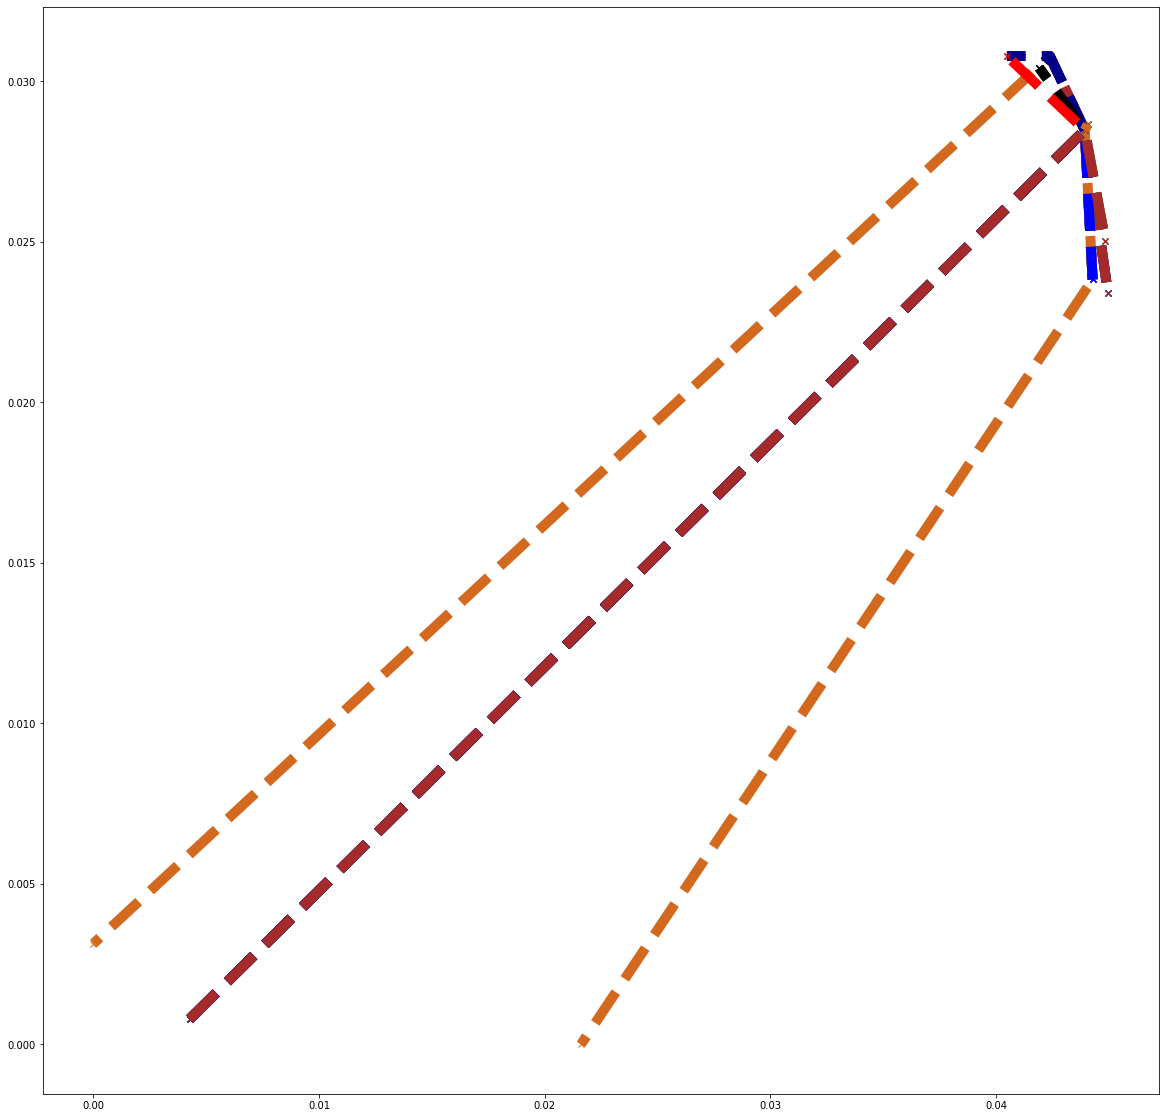

In [19]:
#ip_adress = choice(list(queries_dict.keys()))
ip_adress = '237.34.214.242'
queries = queries_dict[ip_adress]
map_of_one_individual(queries)

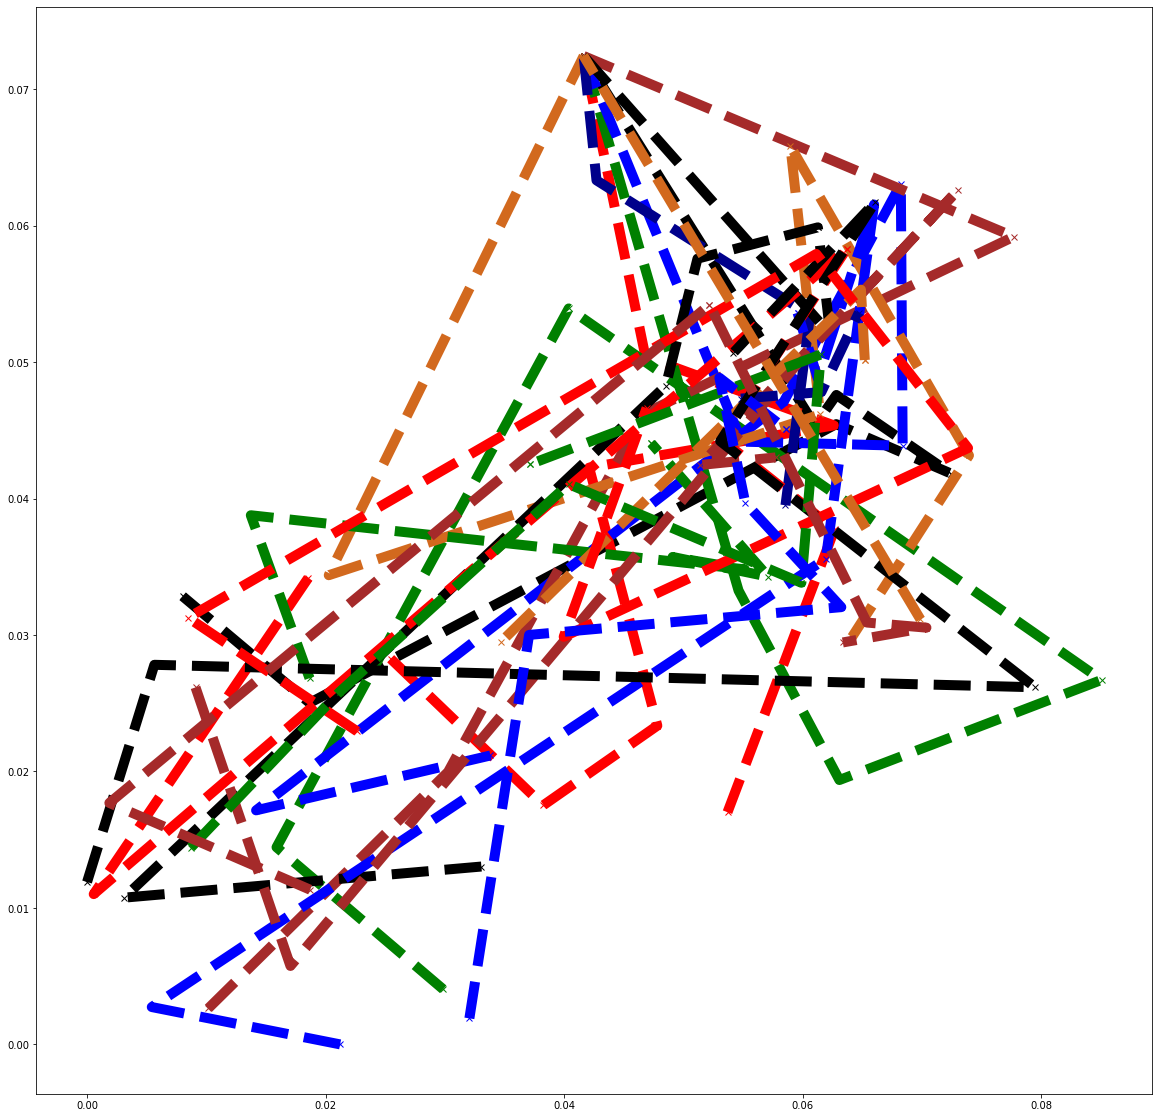

In [20]:
ip_adress = '237.34.214.242'
queries = defense_queries[ip_adress]
map_of_one_individual(queries)

### For User '237.34.214.242' we cannot infer anymore where the user lives or works.

In [21]:
# count the how many times a user does a particular query
def cout(queries):
    noise_lat_mu = (MAX_LAT - MIN_LAT)/10.0
    noise_lon_mu = (MAX_LON - MIN_LON)/10.0
    trajectory_of_the_week_lat = {}
    trajectory_of_the_week_lon = {}    
        # queries are sorted based on time
    for query in queries:
        lat, lon, time, type_poi = query[:]
        day = time // 24
        noise_lat = gauss(noise_lat_mu, noise_lat_mu)
        noise_lon = gauss(noise_lon_mu, noise_lon_mu)
        noise_lat, noise_lon = 0.001, 0.001
        if day not in trajectory_of_the_week_lat.keys():
            trajectory_of_the_week_lat[day] = []
            trajectory_of_the_week_lon[day] = []
        trajectory_of_the_week_lat[day].append((lat - MIN_LAT) + noise_lat)
        trajectory_of_the_week_lon[day].append((lon - MIN_LON) + noise_lon) 
    # for each day we have the trajectory
    color = [ 'black','red', 'green', 'blue','brown','chocolate', 'darkblue', 'purple', 'orange']
    n = len(trajectory_of_the_week_lat.keys())
    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    num_days = len(trajectory_of_the_week_lat.keys())
    #num_days_sqrt = ceil(sqrt(float(num_days)))
    for day in trajectory_of_the_week_lat.keys():
        print(day, " this is a new day")
        x = trajectory_of_the_week_lat[day]
        y = trajectory_of_the_week_lon[day]
        # plot lines
        plt.plot(x, y, color = color[int(day) % 7], linestyle='dashed', marker='x', linewidth = 10)
    plt.show()

In [22]:
# for each user count the number of queries that we 
def where_do_you_leave(queries):
    # first we need to find the max lat and max lon of the individual
    MAX_LAT = float('-inf')
    MAX_LON = float('-inf')
    MIN_LAT = float('inf')
    MIN_LON = float('inf')
    for query in queries:
        MAX_LAT = max(query[0], MAX_LAT)
        MIN_LAT = min(query[0], MIN_LAT)
        MAX_LON = max(query[1], MAX_LON)
        MIN_LON = min(query[1], MIN_LON)
    noise_lat_mu = (MAX_LAT - MIN_LAT)/10.0
    noise_lon_mu = (MAX_LON - MIN_LON)/10.0
    trajectory_of_the_week_lat = {}
    trajectory_of_the_week_lon = {}    
        # queries are sorted based on time
    for query in queries:
        lat, lon, time, type_poi = query[:]
        day = time // 24
        noise_lat = gauss(noise_lat_mu, noise_lat_mu)
        noise_lon = gauss(noise_lon_mu, noise_lon_mu)
        noise_lat, noise_lon = 0.001, 0.001
        if day not in trajectory_of_the_week_lat.keys():
            trajectory_of_the_week_lat[day] = []
            trajectory_of_the_week_lon[day] = []
        trajectory_of_the_week_lat[day].append((lat - MIN_LAT) + noise_lat)
        trajectory_of_the_week_lon[day].append((lon - MIN_LON) + noise_lon) 
    # for each day we have the trajectory
    color = [ 'black','red', 'green', 'blue','brown','chocolate', 'darkblue', 'purple', 'orange']
    n = len(trajectory_of_the_week_lat.keys())
    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    num_days = len(trajectory_of_the_week_lat.keys())
    #num_days_sqrt = ceil(sqrt(float(num_days)))
    for day in trajectory_of_the_week_lat.keys():
        print(day, " this is a new day")
        x = trajectory_of_the_week_lat[day]
        y = trajectory_of_the_week_lon[day]
        # plot lines
        plt.plot(x, y, color = color[int(day) % 7], linestyle='dashed', marker='x', linewidth = 10)
    plt.show()

In [23]:
def sporty_type(queries):
    days = set()
    sporty= 0
    for query in queries:
        lat, lon, time, type_poi = query[:]
        day = time // 24
        days.add(day)
        if type_poi in WORKOUT:
            sporty +=1
        SPORTY_THRESHOLD = 0.5
    if sporty/float(len(days)) > SPORTY_THRESHOLD:
        print("the user is very sporty")
        return True
    else:
        print("the user is not very sporty")
        return False

In [37]:
def weekends(queries):
    days = set()
    pois_during_weekends = []
    for query in queries:
        lat, lon, time, type_poi = query[:]
        if type_poi not in HAVING_FUN:
            continue
        day = int(time // 24) % 7
        if ((day == 6) or (day == 5)):
            pois_during_weekends.append(type_poi)
    pois_during_weekends = list((x,pois_during_weekends.count(x)) for x in set(pois_during_weekends))
    pois_during_weekends.sort(key = lambda x: x[1])
    if not pois_during_weekends:
        return "none"
    elif len(pois_during_weekends) == 1:
        print("the user likes going for drinks at a ", pois_during_weekends[0][0])
        return pois_during_weekends[0][0]
    elif len(pois_during_weekends) == 2:
        a, ac, b, bc = pois_during_weekends[0][0], pois_during_weekends[0][1], pois_during_weekends[1][0], pois_during_weekends[1][1]
        if ac > bc + 2:
            return a
        elif bc > ac + 2:
            return b
        elif bc*ac == 0:
            return "none"
        else:
            return "both"            
        
    return pois_during_weekends[-1]

In [38]:
def sporty_type(queries):
    days = set()
    sporty= 0
    for query in queries:
        lat, lon, time, type_poi = query[:]
        day = time // 24
        days.add(day)
        if type_poi in WORKOUT:
            sporty +=1
        SPORTY_THRESHOLD = 0.5
    if sporty/float(len(days)) > SPORTY_THRESHOLD:
        print("the user is very sporty")
        return True
    else:
        print("the user is not very sporty")
        return False

## How many users are sporty

In [39]:
ip_adresses = queries_dict.keys()
sporty = 0
for ip_adress in ip_adresses:
    queries = defense_queries[ip_adress]
    if sporty_type(queries):
        sporty +=1
print(100.0 * sporty/len(ip_adresses), "% of the users are sporty" )

the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very sporty
the user is very

### All the users are sporty in the new query dataset, so we get zero information from that anymore.

### Statistics of where users prefer to go have a drink in the weekends

In [40]:
bar, club = 0, 0
both, none = 0, 0
for ip_adress in ip_adresses:
    queries = defense_queries[ip_adress]
    preference = weekends(queries)
    if preference == 'both':
        both += 1
    if preference == 'none':
        none += 1
    if preference == 'bar':
        bar += 1
    if preference == 'club':
        club += 1
print(100.0 * both/len(ip_adresses), "% of the users like both bars and clubs" )
print(100.0 * none/len(ip_adresses), "% of the users like neither bars nor clubs" )
print(100.0 * bar/len(ip_adresses), "% of the users like bars" )
print(100.0 * club/len(ip_adresses), "% of the users like clubs" )

88.5 % of the users like both bars and clubs
11.5 % of the users like neither bars nor clubs
0.0 % of the users like bars
0.0 % of the users like clubs


### Most of the uses like both clubs and bars so we cannot get anymore the following information: if a user prefers to go to a bar or to a club.